<a href="https://colab.research.google.com/github/Buterbrod/Deep-Learning-School-2021/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D1%82%D1%82%D0%BE%D0%BA%D0%B0_%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9_(%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание оттока пользователей (весна 2021)

Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS (весна 2021)
- https://www.kaggle.com/c/advanced-dls-spring-2021/overview

----

Вам предстоит **научиться моделировать отток клиентов телеком компании**. 

Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

**Дано:**

На странице с данными вы можете загрузить три файла:
- train.csv: файл с обучающей выборкой (содержит колонки признаков и целевую переменную)
- test.csv: файл с тестовой выборкой (содержит только колонки признаков).
- submission.csv: пример файла с предсказаниями

**Требуется:**

В качестве ответа вам необходимо загрузить предсказания вероятностей ухода клиентов для test.csv.

Названия признаков и целевой пременной есть в baseline ноутбуке. (baseline - базовое решение, с которым обычно сравниают более продвинутые алгоритмы.)

**Решение:**

## Шаг 1. Подключить библиотеки


In [332]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Шаг 2. Подключить Kaggle к Colab и забрать файлы соревнования



Документация:
- [kaggle-api](https://github.com/Kaggle/kaggle-api)
- [инструкция из интернета](https://askdev.ru/q/ispolzovanie-naborov-dannyh-kaggle-v-google-colab-581252)

**Предварительные шаги:**
- зайти на https://www.kaggle.com
- войти в account
- API, Create New API Token
- сохранить JSON на диск для дальнейшего подключения

In [14]:
# Запустить и выбрать kaggle.json, ранее выгруженный файл с Kaggle account страницы
from google.colab import files
files.upload()
None

Saving kaggle.json to kaggle.json


In [15]:
# Убедимся, что kaggle.json файл загрузился
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Oct  7 19:37 kaggle.json


In [16]:
# Установим клиент Kaggle API
!pip install -q kaggle

In [17]:
# Клиент Kaggle API ожидает файл kaggle.json в ~/.kaggle
# Переместим его туда
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Включим warning для Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
# Выведем список файлов соревнования advanced-dls-spring-2021
!kaggle competitions files advanced-dls-spring-2021

name             size  creationDate         
--------------  -----  -------------------  
submission.csv   14KB  2021-03-03 13:03:16  
test.csv        213KB  2021-03-03 13:03:16  
train.csv       648KB  2021-03-03 13:03:16  


In [19]:
# Загрузим все данные по соревнованию с Kaggle на Colab
!kaggle competitions download -p /data/advanced-dls-spring-2021 --force advanced-dls-spring-2021

  0% 0.00/648k [00:00<?, ?B/s]
100% 648k/648k [00:00<00:00, 42.2MB/s]
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 64.2MB/s]
  0% 0.00/14.4k [00:00<?, ?B/s]
100% 14.4k/14.4k [00:00<00:00, 30.0MB/s]


In [20]:
# Выведем список загруженных файлов
!ls /data/advanced-dls-spring-2021

submission.csv	test.csv  train.csv


## Шаг 3. Загрузить начальные данные и посмотреть на них

In [289]:
data_dir = "/data/advanced-dls-spring-2021/"

In [290]:
# train.csv - файл с обучающей выборкой
# содержит колонки признаков и целевую переменную
train_data = pd.read_csv(data_dir + "train.csv")
train_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [291]:
# test.csv - файл с тестовой выборкой.
# содержит только колонки признаков
test_data = pd.read_csv(data_dir + "test.csv")
test_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [292]:
#submission.csv -  файла с предскзааниями
subm_data = pd.read_csv(data_dir + "submission.csv")
print('Размерность: '+str(subm_data.shape))
subm_data.head()

Размерность: (1761, 2)


,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [293]:
print('Размерность тренировочных данных: '+str(train_data.shape))
print('Размерность тестовых данных: '+str(test_data.shape))
print('Всего данных: ' + str(train_data.shape[0]) + ' + ' + str(test_data.shape[0]) +
      ' = ' + str((train_data.shape[0]) + test_data.shape[0]))

Размерность тренировочных данных: (5282, 20)
Размерность тестовых данных: (1761, 19)
Всего данных: 5282 + 1761 = 7043


### Шаг 4. Разбор и преобразование дата модели

In [294]:
train_data.columns[-1]

'Churn'

In [347]:
# Объединим массив тестовых и проверочных данных, чтобы работать одинаково с массивами
all_data_1 = train_data
all_data_1['IsTrainData'] = 1
all_data_2 = test_data
all_data_2['Churn'] = 1
all_data_2['IsTrainData'] = 0
all_data = pd.concat([all_data_1, all_data_2], axis=0)

# Колонка 'TotalSpent' - строковая, но содержит float данные и пробельные значения
# Преобразуем пробелы в None-значения
all_data.loc[all_data['TotalSpent']==' ', ('TotalSpent')] = np.nan
# Сконвертируем в число
all_data['TotalSpent'] = pd.to_numeric(all_data['TotalSpent'])

# Уберем из модели строки с NULL значениями
all_data = all_data.dropna()

In [348]:
# Разделим поля по типам: численные / категориальные
numeric_indeces = np.array([0, 1, 2, 4, 19, 20])
categorical_indeces = np.array([3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

# Положим их в соответствующие массивы
numeric_data = all_data[all_data.columns[numeric_indeces]]
categorical_data = all_data[all_data.columns[categorical_indeces]]

all_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,IsTrainData
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0,1
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,1
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0,1
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0,1


In [316]:
# Выведем численные данные
numeric_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn,IsTrainData
0,55,19.50,1026.35,0,0,1
1,72,25.85,1872.20,0,0,1
2,1,75.90,75.90,0,1,1
3,32,79.30,2570.00,1,0,1
4,60,115.25,6758.45,0,0,1


In [317]:
# Выведем категориальные данные
categorical_data.head()

,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,Male,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,Male,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,Male,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,Female,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,Female,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [349]:
# Выведем данные категориальных столбцов
for column_name in categorical_data.columns:
    print(len(test_data[column_name].unique()), column_name + ':', test_data[column_name].unique())

2 Sex: ['Male' 'Female']
2 HasPartner: ['Yes' 'No']
2 HasChild: ['No' 'Yes']
2 HasPhoneService: ['Yes' 'No']
3 HasMultiplePhoneNumbers: ['Yes' 'No' 'No phone service']
3 HasInternetService: ['DSL' 'Fiber optic' 'No']
3 HasOnlineSecurityService: ['Yes' 'No' 'No internet service']
3 HasOnlineBackup: ['No' 'Yes' 'No internet service']
3 HasDeviceProtection: ['No' 'Yes' 'No internet service']
3 HasTechSupportAccess: ['No' 'Yes' 'No internet service']
3 HasOnlineTV: ['No' 'Yes' 'No internet service']
3 HasMovieSubscription: ['No' 'Yes' 'No internet service']
3 HasContractPhone: ['One year' 'Month-to-month' 'Two year']
2 IsBillingPaperless: ['No' 'Yes']
4 PaymentMethod: ['Credit card (automatic)' 'Electronic check' 'Bank transfer (automatic)'
 'Mailed check']


In [350]:
# применим к ним One-Hot Encoding
dummies = pd.get_dummies(categorical_data)
print('Размер категориальных данных до: '+str(categorical_data.shape)+', после One-Hot Encoding: '+str(dummies.shape))

Размер категориальных данных до: (7032, 15), после One-Hot Encoding: (7032, 41)


In [351]:
# Объединим преобразованные после One-Hot Encoding данные вместе
X = pd.concat([numeric_data, dummies], axis=1)

# Разложим данные по переменным
X_origin = all_data
X_train = X[X['IsTrainData'] == 1]                      .drop(['IsTrainData', 'Churn'], axis=1)
X_train_origin = X_origin[X_origin['IsTrainData'] == 1] .drop(['IsTrainData', 'Churn'], axis=1)
X_test = X[X['IsTrainData'] == 0]                       .drop(['IsTrainData', 'Churn'], axis=1)
X_test_origin = X_origin[X_origin['IsTrainData'] == 0]  .drop(['IsTrainData', 'Churn'], axis=1)

X = X.drop(['IsTrainData', 'Churn'], axis=1)
X_origin = X_origin.drop(['IsTrainData', 'Churn'], axis=1)

Y = all_data[all_data['IsTrainData'] == 1]['Churn']

print('X:       ', X.shape, X_origin.shape)
print('X_train: ', X_train.shape, X_train_origin.shape, Y.shape)
print('X_test:  ', X_test.shape, X_test_origin.shape)

X:        (7032, 45) (7032, 19)
X_train:  (5273, 45) (5273, 19) (5273,)
X_test:   (1759, 45) (1759, 19)


## Шаг 5. Обучаем алгоритмы.

In [352]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [353]:
# Утянем себе красивую процедурку отсюда: 
# https://colab.research.google.com/drive/163o53qfrOvs1_lEGBlV2NYW3K8LQPgXo#scrollTo=DsIxH1vZvh-l
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='f1',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [354]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [355]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

In [356]:
[np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]

[array([ 4,  7, 11, 15, 18, 22, 26, 30]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.0s finished


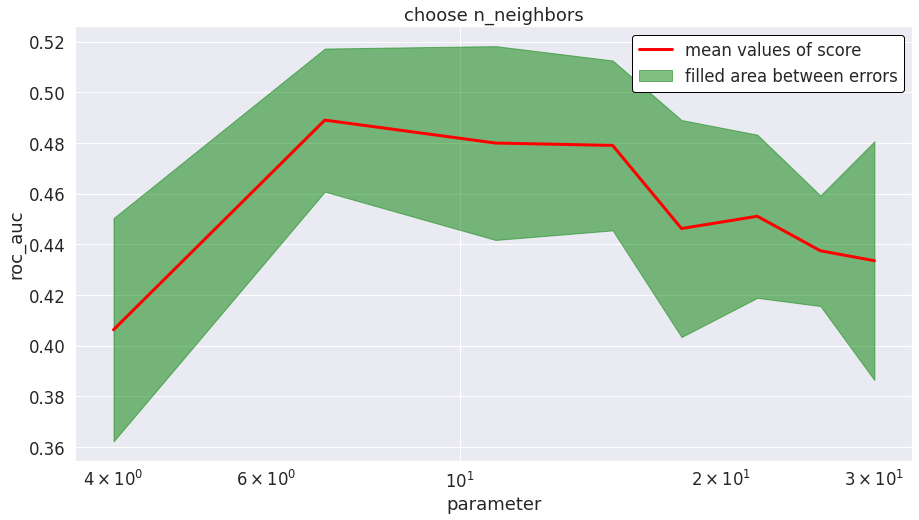

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0460s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0648s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1787s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    3.6s finished


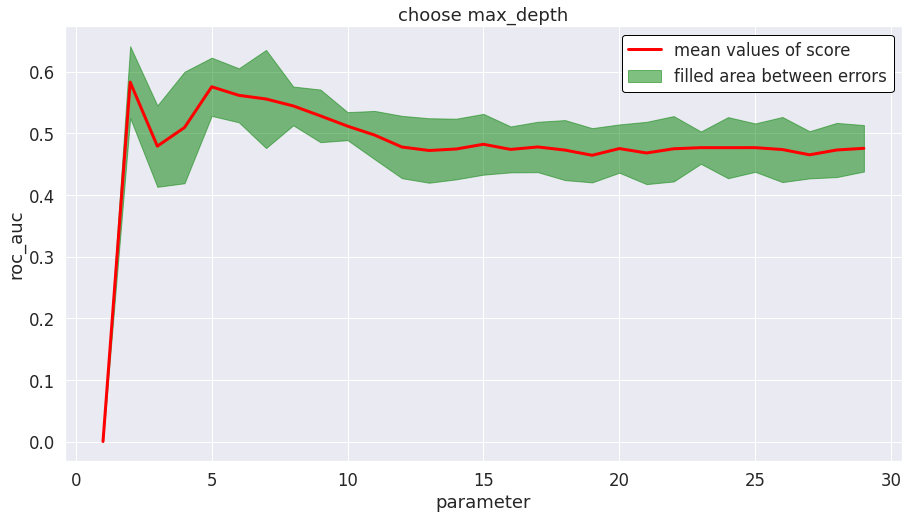

In [357]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, Y, model, param_name, grid, param_scale)